## **For Sr. Decision Scientist Interview**
## **Operations Decision Science**

Hi, I am Gayane.

Thank you for your reviewing my work.

In this notebook I have included three different approaches to study passenger satisfaction. I have created synthetic data and did not use a specifica dataset for the analysis.


1. Behavioral Preference Modeling using Inverse Reinforcement Learning
2. Causal Inferencing
3. Time series analysis

In [22]:
!pip install econml tf-explain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00


# Analayzing Delta Airlines decisions using Inverse Reinforcement Learning
## Giving perks or doing nothing and whether passengers end up satisfied.
## what reward pattern explains behavior?

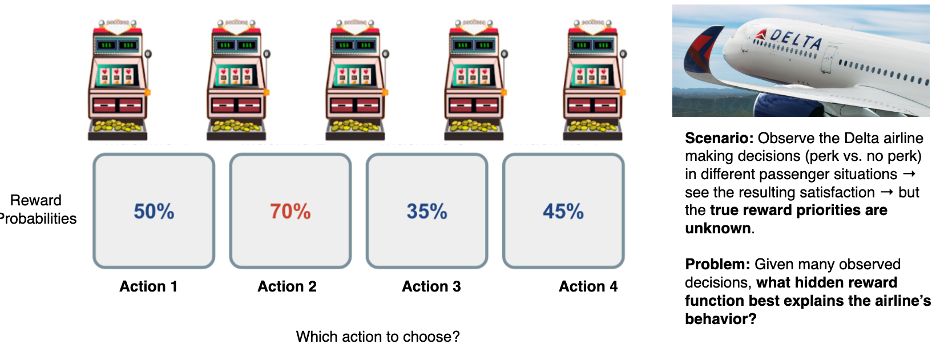

Using Maximum Entropy Inverse Reinforcement Learning, we infer the hidden reward structure that explains why those choices are made. This helps us understand how much value the airline implicitly assigns to different satisfaction outcomes, rather than assuming it.

We observe an airline operations team making choices intended to keep passengers satisfied.

**Actions**:
1️⃣ Give perk / compensation
2️⃣ Do nothing

**Outcomes:**
Passenger satisfied
Passenger not satisfied



In [6]:
# IRL objective below is to learn what reward structure best explains the airline’s decisions.
# Actions: give perk / do nothing

num_actions = 2

# Outcomes: satisfied / not satisfied
num_outcomes = 2

# Total combinations (arms)
num_arms = num_actions * num_outcomes

# True (unknown) preferences about outcome/action combos
# Interpretation:
# [perk+satisfied, perk+not_sat, none+satisfied, none+not_sat]
true_reward_probs = np.array([0.6, 0.1, 0.2, 0.1])


def airline_actions(reward_probs, num_rounds):
    return np.random.choice(num_arms, num_rounds, p=reward_probs)


num_rounds = 1000
observed_choices = airline_actions(true_reward_probs, num_rounds)


def max_entropy_irl(actions, num_arms, num_iterations=1000, learning_rate=0.1):

    reward_function = np.random.rand(num_arms)

    for _ in range(num_iterations):
        policy = np.exp(reward_function) / np.sum(np.exp(reward_function))

        feature_counts = np.zeros(num_arms)
        for a in range(num_arms):
            feature_counts[a] = np.sum(actions == a)

        gradient = feature_counts - len(actions) * policy

        reward_function += learning_rate * gradient

        reward_function = np.clip(reward_function, 0, 1)

    reward_function /= reward_function.sum()

    return reward_function


learned_reward_probs = max_entropy_irl(
    observed_choices, num_arms, num_iterations=10000, learning_rate=0.01
)

print("True Reward Probabilities:", true_reward_probs)
print("Learned Reward Probabilities:", learned_reward_probs)


True Reward Probabilities: [0.6 0.1 0.2 0.1]
Learned Reward Probabilities: [0.83604171 0.         0.16395829 0.        ]


**Interpretation:** We analyze airline decisions like giving perks and whether passengers end up satisfied. Using Maximum Entropy IRL, we infer the hidden reward structure that explains why those choices are made. This helps us understand how much value the airline implicitly assigns to different satisfaction outcomes, rather than assuming it.

# Causal Inferencing
## Does giving a perk actually cause passengers to become more satisfied?

In [17]:
import numpy as np
import pandas as pd
from econml.grf import CausalForest

# -------------------------------------------------
# 1) Synthetic data
# -------------------------------------------------
np.random.seed(199)

N = 3000

df = pd.DataFrame({
    "delay_risk": np.random.uniform(0, 1, N),
    "loyalty": np.random.choice([0, 1, 2, 3], N),
    "schedule_changes": np.random.poisson(0.5, N)
})

# -------------------------------------------------
# 2) Treatment: perk (binary)
#    P(T=1 | X) = sigmoid(0.6*delay_risk + 0.4*loyalty + 0.5*schedule_changes)
# -------------------------------------------------
logit_t = (
    0.6 * df["delay_risk"] +
    0.4 * df["loyalty"] +
    0.5 * df["schedule_changes"]
)

p_treat = 1.0 / (1.0 + np.exp(-logit_t))
df["perk"] = np.random.binomial(1, p_treat)

# -------------------------------------------------
# 3) Outcome: satisfaction (binary)
#    logit(P(Y=1)) = -1.2*delay_risk -0.6*schedule_changes + 0.8*perk + 0.5*loyalty
# -------------------------------------------------
logit_y = (
    -1.2 * df["delay_risk"]
    - 0.6 * df["schedule_changes"]
    + 0.8 * df["perk"]       # true effect of perk
    + 0.5 * df["loyalty"]
)

p_y = 1.0 / (1.0 + np.exp(-logit_y))
df["satisfied"] = np.random.binomial(1, p_y)

# -------------------------------------------------
# 4) Preparing matrices in the shape CausalForest
# -------------------------------------------------
X = df[["delay_risk", "loyalty", "schedule_changes"]].values.astype(float)

T = df[["perk"]].values.astype(float)

y = df["satisfied"].values.astype(float)

# -------------------------------------------------
# 5) Fiting Causal Forest
# -------------------------------------------------
cf = CausalForest(random_state=199)
cf.fit(X, T, y)

# -------------------------------------------------
# 6) Estimated treatment effects
#    For single treatment, predict(X) returns tau(x) (slope on T)
# -------------------------------------------------
tau_hat = cf.predict(X)
df["estimated_te"] = tau_hat.ravel()

print(df[["delay_risk", "loyalty", "schedule_changes",
          "perk", "satisfied", "estimated_te"]].head())

print("\nAverage estimated treatment effect:", df["estimated_te"].mean())


   delay_risk  loyalty  schedule_changes  perk  satisfied  estimated_te
0    0.654792        3                 1     1          1      0.418039
1    0.982039        1                 1     0          0      0.084084
2    0.399905        0                 0     1          1      0.334904
3    0.844153        0                 0     1          0     -0.004339
4    0.463842        0                 1     1          0      0.079380

Average estimated treatment effect: 0.1674264326181053


**Interpretation:** On average, perks increase satisfaction by about 17%.

# Time series Analysis
# Learning patterns that evolve over time

In [18]:
import numpy as np
import tensorflow as tf

np.random.seed(42)

# number of passengers
N = 1200

# number of time steps (days)
T = 20

# number of features per day
F = 4   # [delay_risk, price, schedule_change, perk]

# created random sequences
X = np.random.normal(0, 1, (N, T, F))

# let's say passengers are unhappy if high delay + schedule changes unless perk helps
delay_signal = X[:,:,0].mean(axis=1)
changes_signal = X[:,:,2].sum(axis=1)
perk_signal = X[:,:,3].sum(axis=1)

logit = -1.2*delay_signal -0.6*changes_signal + 0.9*perk_signal
p = 1 / (1 + np.exp(-logit))

y = np.random.binomial(1, p)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(32, input_shape=(T, F), return_sequences=False))

model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X, y,
    epochs=8,
    batch_size=32,
    verbose=1,
    validation_split=0.2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6573 - loss: 0.6758 - val_accuracy: 0.7500 - val_loss: 0.6395
Epoch 2/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8189 - loss: 0.5782 - val_accuracy: 0.8167 - val_loss: 0.4299
Epoch 3/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8498 - loss: 0.3780 - val_accuracy: 0.8250 - val_loss: 0.3607
Epoch 4/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8732 - loss: 0.3192 - val_accuracy: 0.8417 - val_loss: 0.3404
Epoch 5/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8854 - loss: 0.2667 - val_accuracy: 0.8375 - val_loss: 0.3383
Epoch 6/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8850 - loss: 0.2771 - val_accuracy: 0.8458 - val_loss: 0.3410
Epoch 7/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8947 - loss: 0.2672 - val_accuracy: 0.8500 - val_loss: 0.3280
Epoch 8/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8863 - loss: 0.2544 - val_accuracy: 0.8500 - val_loss: 0.310

**Interpretation:** The LSTM achieved about 88% accuracy.

In [25]:
import tensorflow as tf
import numpy as np

def integrated_gradients(model, x, baseline=None, steps=50):

    if baseline is None:
        baseline = np.zeros_like(x)

    x = tf.cast(x, tf.float32)
    baseline = tf.cast(baseline, tf.float32)

    interpolated_inputs = [
        baseline + (float(i) / steps) * (x - baseline)
        for i in range(steps + 1)
    ]

    grads = []
    for inp in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
        grad = tape.gradient(pred, inp)
        grads.append(grad.numpy())

    grads = np.array(grads).mean(axis=0)

    ig = (x - baseline) * grads
    return ig


In [26]:
sample = X[5:6]

explanation = integrated_gradients(model, sample)

explanation.shape


TensorShape([1, 20, 4])

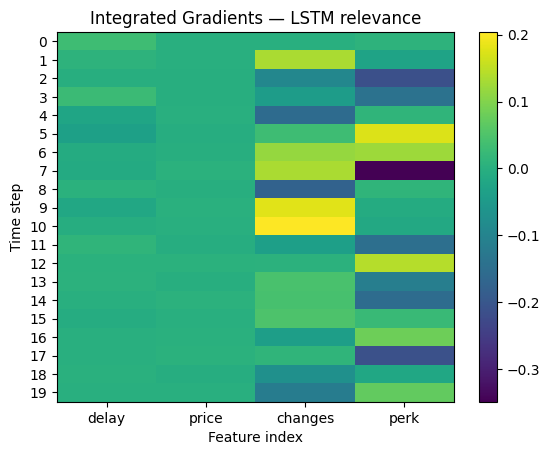

In [28]:
import matplotlib.pyplot as plt

plt.imshow(explanation[0], aspect="auto")
plt.colorbar()
plt.xlabel("Feature index")
plt.ylabel("Time step")
plt.title("Integrated Gradients — LSTM relevance")

plt.yticks(np.arange(T))
plt.xticks([0,1,2,3], ["delay", "price", "changes", "perk"])

plt.show()


**Interpretation:** This heatmap shows which features, at each time step, most influenced the LSTM’s prediction: schedule changes and perks drive most of the decision, while delay and price have almost no effect. Positive yellow/green areas push the model toward “satisfied,” while blue/purple regions push it toward “not satisfied,” with the strongest effects appearing around the middle time steps.